# Training with Background Data

## We wrote this code with the help of the following scripts

https://github.com/dipuk0506/SpinalNet/blob/master/Transfer%20Learning/Pytorch_data_to_folders.py

https://github.com/dipuk0506/SpinalNet/blob/master/Transfer%20Learning/Transfer_Learning_STL10.py

https://www.kaggle.com/code/luckily66/yuan-monocnn

In [1]:
import torch, time, os, copy, random, imageio, os, shutil, numpy, zipfile
import matplotlib.pyplot as plt, pandas as pd, seaborn as sn, torch.nn as nn
from torchvision import datasets, models, transforms, utils
from sklearn.metrics import confusion_matrix

### Create Directories and Extract Background Data

In [2]:
Num_class=10
folderlocation = './data/CIFAR10/'

def create_dir(folderlocation):
    if not os.path.exists(folderlocation):
        os.mkdir(folderlocation)
    
create_dir('./data/')
create_dir(folderlocation)
for iterf in ['train/', 'valid/', 'test/']:
    create_dir(folderlocation + iterf)
    for iter1 in range(Num_class): 
        create_dir(folderlocation + iterf + str(iter1)) 
for iterf in ['train/', 'valid/']:
    create_dir(folderlocation + iterf + str(999)) 

create_dir('./Background/')
with zipfile.ZipFile('/kaggle/input/background-image-data/Background_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./Background/')

### Copy Background Data to train and validation folders

In [3]:
image_index = 0
for dirpath, dirnames, filenames in os.walk('./Background/'):
    for fname in filenames:
        if image_index == 2000: 
            shutil.copyfile(path, folderlocation + 'valid/'+str(999)+'/'+str(image_index) + fname[-9:])
            #break 
        path = os.path.join(dirpath,fname)
        shutil.copyfile(path, folderlocation + 'train/'+str(999)+'/'+str(image_index) + fname[-9:])
        image_index = image_index +1

### Download data and copy to folders

In [4]:
data_train = datasets.CIFAR10('/files/', train=True, download=True,
                             transform=transforms.Compose([ ]))
        
for iter1 in range(len(data_train)):
    x, a = data_train[iter1] 
    imageio.imwrite(folderlocation + 'train/'+str(a)+'/train'+str(iter1)+'.png', x) 
        
data_test = datasets.CIFAR10('/files/', train=False, download=True,
                             transform=transforms.Compose([ ]))

for iter1 in range(len(data_test)):
    x, a = data_test[iter1] 
    imageio.imwrite(folderlocation + 'valid/'+str(a)+'/valid'+str(iter1)+'.png', x)
    
for iter1 in range(len(data_test)):
    x, a = data_test[iter1] 
    imageio.imwrite(folderlocation + 'test/'+str(a)+'/test'+str(iter1)+'.png', x)

100%|██████████| 170M/170M [00:04<00:00, 35.0MB/s]


Extracting /files/cifar-10-python.tar.gz to /files/
Files already downloaded and verified


### Dataloaders

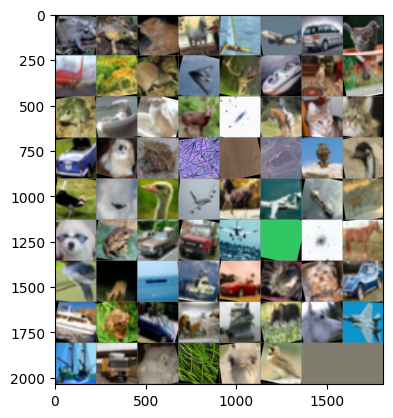

In [5]:
# Data augmentation and normalization for training
# Just normalization for validation

im_dimention = 224

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((244,244)),
        transforms.RandomRotation(15,),
        transforms.RandomCrop(im_dimention),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize((im_dimention,im_dimention)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(folderlocation, x),
                                          data_transforms[x])
                  for x in ['train', 'valid','test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=70,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'valid']}

dataloaders_test = {'test': torch.utils.data.DataLoader(image_datasets['test'], batch_size=30,
                                             shuffle=False, num_workers=0)}
# data_transforms['test']
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = numpy.array([0.507, 0.487, 0.441])
    std = numpy.array([0.267, 0.256, 0.276])
    inp = std * inp + mean
    inp = numpy.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = utils.make_grid(inputs)

imshow(out)

### Model and Training functions

In [6]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

'''
Changing the fully connected layer 
'''
model_ft.fc = nn.Linear(num_ftrs, Num_class+1)

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
          
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


### Training

In [7]:
model_ft = model_ft.to(device)
criterion = torch.nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1) 

Epoch 0/0
----------
train Loss: 0.6445 Acc: 0.8158
valid Loss: 0.2148 Acc: 0.9316

Training complete in 6m 37s
Best val Acc: 0.931607


### Testing by Discarding the Background Class

In [8]:
y_pred = []
y_true = []
output_all =[]

# iterate over test data
for inputs, labels in dataloaders_test['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs) # Feed Network
        output = output[:,0:Num_class] # Discarding Background Class
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

Test Accuracy: 0.932


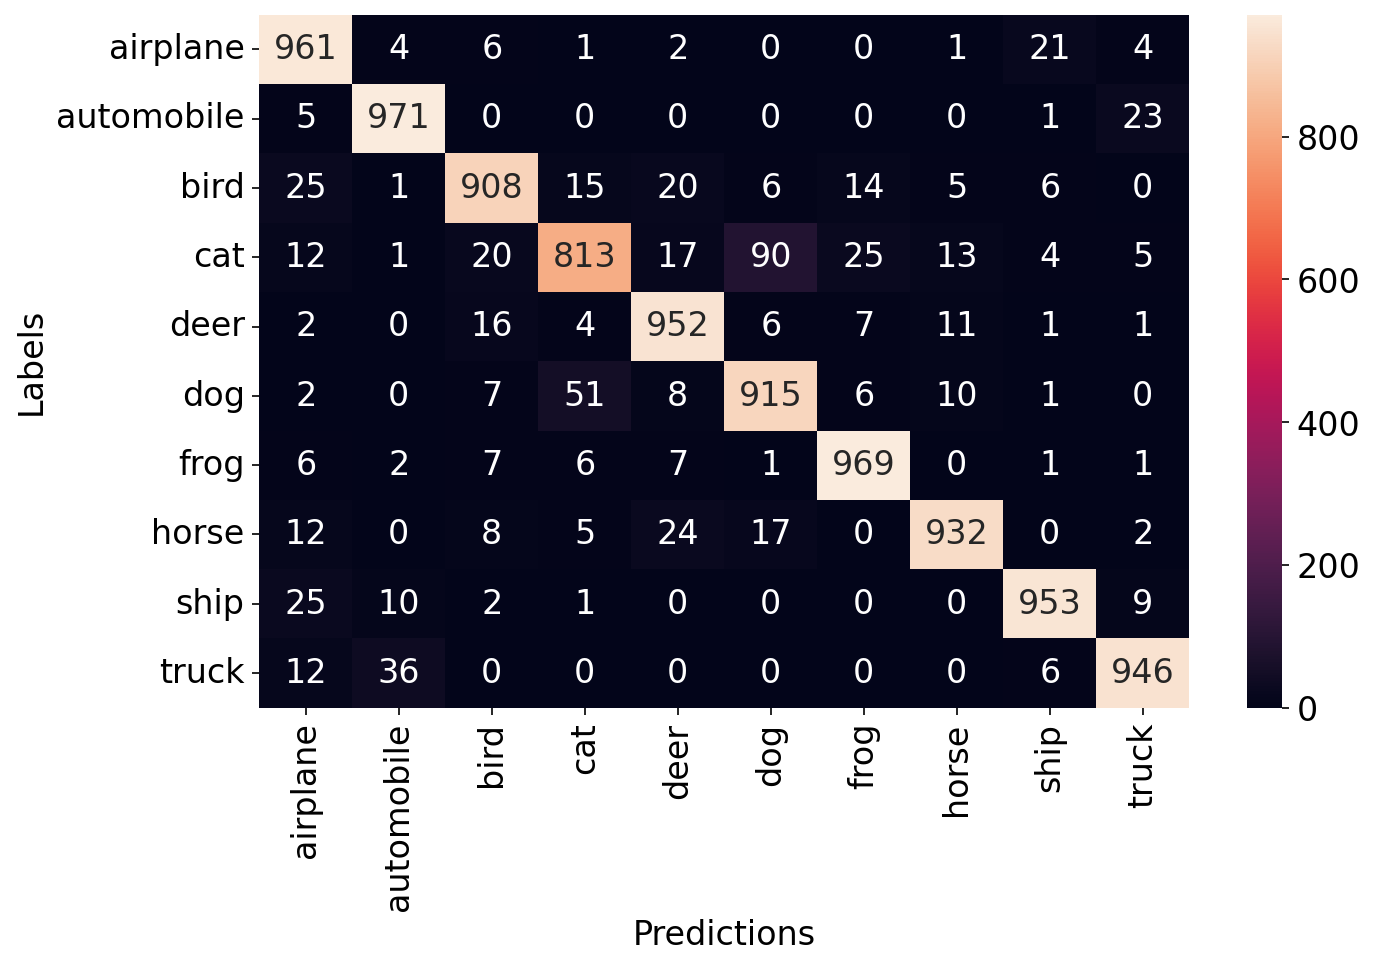

In [9]:
test_accuracy = 0
for iter1 in range(len(y_true)):
    if y_true[iter1] == y_pred[iter1]:
        test_accuracy = test_accuracy + 1

print('Test Accuracy:',test_accuracy/len(y_true))

# constant for classes
classes = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])



plt.figure(figsize = (10,6),dpi=150)
plt.rcParams['font.size'] = '16'
fig = sn.heatmap(df_cm, annot=True, fmt=".0f")
plt.ylabel("Labels")
plt.xlabel("Predictions")
plt.show(fig)

fig.figure.savefig('Confusion_test.pdf', bbox_inches = 'tight') 

# Save Model

In [10]:
PATH = "./model_background.pt"
torch.save(model_ft.state_dict(), PATH)

'''
#Guideline for loading model in future 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.wide_resnet101_2(pretrained=False) 
        #We only need the structure to transfer parameters
        
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, Num_class)

model.load_state_dict(torch.load(PATH2, map_location=device))
'''

'\n#Guideline for loading model in future \ndevice = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")\nmodel = models.wide_resnet101_2(pretrained=False) \n        #We only need the structure to transfer parameters\n        \nnum_ftrs = model.fc.in_features\nmodel.fc = nn.Linear(num_ftrs, Num_class)\n\nmodel.load_state_dict(torch.load(PATH2, map_location=device))\n'

## Library file for CIFAR-10C

Collected from: https://www.kaggle.com/code/luckily66/yuan-monocnn

In [11]:
%%writefile cifar.py
import os
import hashlib
import numpy as np

from PIL import Image
import torch.utils.data as data

# Corrupted CIFAR-10/100 from https://github.com/hendrycks/robustness
# Data downloaded from https://drive.google.com/drive/folders/1HDVw6CmX3HiG0ODFtI75iIfBDxSiSz2K
# 19 different corruption types, in each type, 5 different severity
# organized as follows [severity 1: 1-10,000; severity 2: 1-10,000, ...,
# severity 5: 1-10,000].
class CorruptedCIFAR(data.Dataset):

    corruption_types = [
        'brightness', 'contrast', 'defocus_blur', 'elastic_transform',
        'fog', 'frost', 'gaussian_blur', 'gaussian_noise',
        'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur',
        'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter',
        'speckle_noise', 'zoom_blur'
    ]

    def __init__(self, root, corruption_type=None,
                 transform=None, target_transform=None):
        self.corrupted_data_root = os.path.expanduser(root)
        self.transform = transform
        self.target_transform = target_transform

        self.test_data = []
        self.test_labels = []
        if corruption_type is None:
            for c_type in self.corruption_types:
                self.test_data.append(np.load(os.path.join(self.corrupted_data_root,
                                                           '{}.npy'.format(c_type))))
                self.test_labels += np.load(os.path.join(self.corrupted_data_root,
                                                         'labels.npy')).tolist()
        else:
            self.test_data.append(np.load(os.path.join(self.corrupted_data_root,
                                                       '{}.npy'.format(corruption_type))))
            self.test_labels += np.load(os.path.join(self.corrupted_data_root,
                                                     'labels.npy')).tolist()

        self.test_data = np.concatenate(self.test_data, axis=0)

    def __getitem__(self, index):
        """
        Args:
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        img, target = self.test_data[index], self.test_labels[index]

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            target = self.target_transform(target)

        return img, target

    def __len__(self):
        return len(self.test_data)

    def __repr__(self):
        fmt_str = 'Dataset ' + self.__class__.__name__ + '\n'
        fmt_str += '    Number of datapoints: {}\n'.format(self.__len__())
        tmp = 'test'
        fmt_str += '    Split: {}\n'.format(tmp)
        fmt_str += '    Root Location: {}\n'.format(self.corrupted_data_root)
        tmp = '    Transforms (if any): '
        fmt_str += '{0}{1}\n'.format(tmp, self.transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        tmp = '    Target Transforms (if any): '
        fmt_str += '{0}{1}'.format(tmp, self.target_transform.__repr__().replace('\n', '\n' + ' ' * len(tmp)))
        return fmt_str

Writing cifar.py


## Test on CIFAR-10C

In [12]:
def test(net, testloader):
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0

    correct_sample_indices = []
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            outputs = outputs[:,0:Num_class] # Discarding Background Class
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct_sample_indices.extend(predicted.eq(targets).cpu().detach().numpy().tolist())
            correct += predicted.eq(targets).sum().item()

            if total >= 10000:
                break
    print('Test Loss: {:.3f} | Acc: {:.3f} ({:d}/{:d})'.format(
        test_loss / (batch_idx + 1), 100. * correct / total, correct, total))

    return 100. * correct / total, numpy.where(correct_sample_indices)[0]



In [13]:
from cifar import CorruptedCIFAR

corruption_types = [
    'brightness', 'contrast', 'defocus_blur', 'elastic_transform',
    'fog', 'frost', 'gaussian_blur', 'gaussian_noise',
    'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur',
    'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter',
    'speckle_noise', 'zoom_blur'
]

corrupt_data = '/kaggle/input/cifar-10-c-2/CIFAR-10-C'

print("\nEvaluating on corrupted CIFAR-10 testset")
for c_type in corruption_types:
    print('corruption type: {}'.format(c_type))
    corrupt_testset = CorruptedCIFAR(root=corrupt_data, corruption_type=c_type, transform = data_transforms['test'])
    corrupt_testloader = torch.utils.data.DataLoader(
        corrupt_testset, batch_size=30, shuffle=False, num_workers=2)

    corrupt_acc, _ = test(model_ft, corrupt_testloader)


Evaluating on corrupted CIFAR-10 testset
corruption type: brightness
Test Loss: 0.217 | Acc: 93.064 (9325/10020)
corruption type: contrast
Test Loss: 0.222 | Acc: 93.024 (9321/10020)
corruption type: defocus_blur
Test Loss: 0.217 | Acc: 93.084 (9327/10020)
corruption type: elastic_transform
Test Loss: 0.321 | Acc: 89.441 (8962/10020)
corruption type: fog
Test Loss: 0.212 | Acc: 93.253 (9344/10020)
corruption type: frost
Test Loss: 0.283 | Acc: 90.838 (9102/10020)
corruption type: gaussian_blur
Test Loss: 0.217 | Acc: 93.064 (9325/10020)
corruption type: gaussian_noise
Test Loss: 0.683 | Acc: 77.645 (7780/10020)
corruption type: glass_blur
Test Loss: 1.180 | Acc: 58.054 (5817/10020)
corruption type: impulse_noise
Test Loss: 0.722 | Acc: 76.307 (7646/10020)
corruption type: jpeg_compression
Test Loss: 0.512 | Acc: 82.784 (8295/10020)
corruption type: motion_blur
Test Loss: 0.302 | Acc: 89.800 (8998/10020)
corruption type: pixelate
Test Loss: 0.302 | Acc: 89.960 (9014/10020)
corruption t

# Delete Downloaded Data

In [14]:
shutil.rmtree('./data/')
shutil.rmtree('./Background/')